# Launching simulation based on unscaled coordinates

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
sys.path.append('/Users/riverr/Documents/pyfel1d/main/')
from particles import ParticleLoader
from fel import OneDFELSolver, LinearTheory
from converter import FELScalingConverter
import time

In this example we show how to generate a OneDFELSolver object based on unscaled coordinates and plot powers and pulse energies in real units.

In [45]:
Ipk = 4e3 # 4 kA peak current
gamma0 = 10e9/0.511e6 # 10 GeV reference energy
lamu = 0.025 # 2.5 cm undulator period
lamr0 = 1.5e-10 # 1.5 Angstrom reference wavelength

nemit = 0.4e-6 # 0.4 um normalized emittance (only used to calculate beam size) 
beta = 20 # 20 meter beta function (only used to calculate beam size)
emit = nemit / gamma0
sigx = np.sqrt(emit*beta)
print(sigx)

Lz = 40 # 40 meter long undulator

bunch_length = 10e-15*3e8 # 10 fs bunch length

Ls = 1.5*bunch_length # beam window 50% longer than bunch

dz = 3*lamu # integration step is three undulator periods
ds = 10*lamr0 # slice length is 10 radiation wavelengths

convert = FELScalingConverter(Ipk=Ipk, gamma0=gamma0, lamr0=lamr0, lamu=lamu, sigx=sigx, Lz=Lz, dz=dz, Ls=Ls, ds=ds)

solver = convert.get_solver()

2.0218803129760177e-05


In [46]:
convert.rho1D # 1D pierce parameter

0.0006863536870282107

In [47]:
convert.calculate_rho3D(emit=0, sigdelta=0) # 3D Pierce parameter including only diffraction

0.0006352031031240633

In [48]:
print(f'Normalized undulator length: {solver.Lzhat}')
print(f'Normalized undulator stepsize: {solver.dzhat}')
print(f'Number of integration steps: {solver.Nzhat}')

print(f'Normalized beam window: {solver.Lzeta}')
print(f'Normalized zeta stepsize: {solver.dzeta}')
print(f'Number of slices: {solver.Nzeta}')

Normalized undulator length: 13.799959685965407
Normalized undulator stepsize: 0.025891106352655548
Number of integration steps: 533
Normalized beam window: 258.7492441118514
Normalized zeta stepsize: 0.0862497480372838
Number of slices: 3000


In [49]:
# supergaussian beam profile 

s = solver.s_arr

chi_s0 = s.mean()
chi_fwhm = bunch_length
supergauss_P = 3

solver.chi = np.exp(-np.log(2)*(4*(s-chi_s0)**2/chi_fwhm**2)**supergauss_P)

Text(0, 0.5, 'Beam profile $\\chi$')

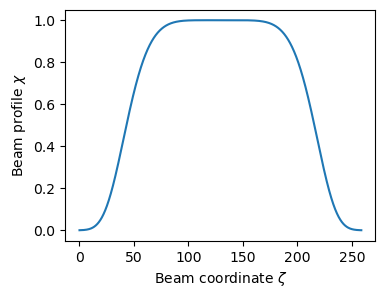

In [31]:
plt.figure(figsize=(4,3))
plt.plot(solver.zeta_arr, solver.chi)
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel(r'Beam profile $\chi$')

In [50]:
# generate initial particle coordinates using simplified function 
solver.generate_beam_simple(shift_MeV=0.0, espread_MeV=0.0, shotnoise=1) # generate a beam with no energy spread at reference energy with shotnoise

In [33]:
solver.run_simulation(steps_between_store=10,
                      verbose=True)

Found no input harmonics array, assuming only first harmonic present
Found no input taper array, assuming it is zero everywhere
Input seed field $a_0$ is unspecified, setting it to zero
Beginning simulation including harmonics: [1]
0% done
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
89% done
99% done
Done


In [34]:
convert.convert_solver_results(solver) # convert simulation results to unscaled (physical) variables

Text(0, 0.5, 'Undulator coordinate z (m)')

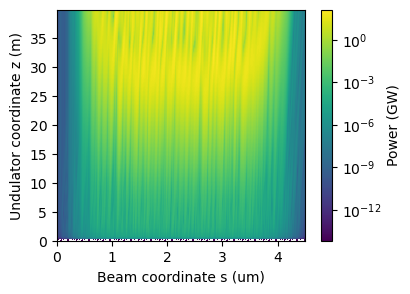

In [36]:
plt.figure(figsize=(4,3))
plt.imshow(1e-9*solver.P_store, norm=LogNorm(), aspect='auto', origin='lower', extent=[0, solver.s_arr.max()*1e6, 0, solver.z_arr.max()])
plt.colorbar(label='Power (GW)')
plt.xlabel('Beam coordinate s (um)')
plt.ylabel('Undulator coordinate z (m)')

Text(0, 0.5, 'Pulse energy (mJ)')

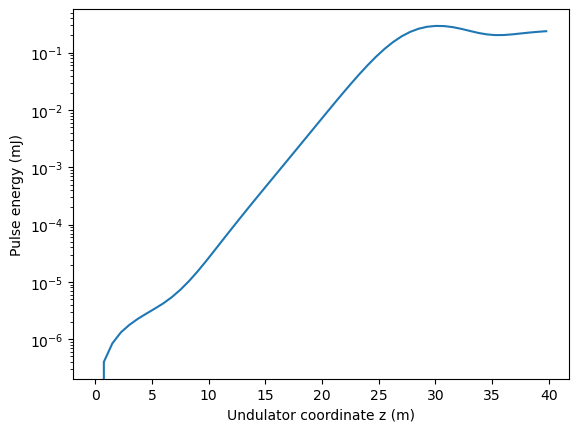

In [37]:
plt.plot(solver.z_store, 1e3*solver.U_store)
plt.yscale('log')
plt.xlabel('Undulator coordinate z (m)')
plt.ylabel('Pulse energy (mJ)')

Text(0, 0.5, 'Power (GW)')

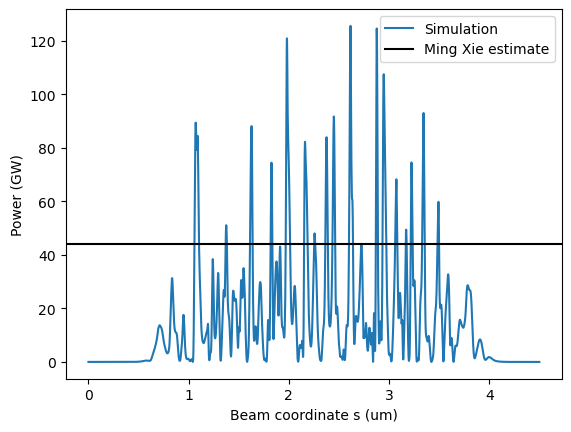

In [39]:
plt.plot(1e6*solver.s_arr, 1e-9*solver.P_final, label='Simulation')

est_sat_power_GW = 1.6*convert.rho*convert.Ipk/1e3*convert.energy_MeV
plt.axhline(est_sat_power_GW, color='k', label='Ming Xie estimate')
plt.legend()
plt.xlabel("Beam coordinate s (um)")
plt.ylabel("Power (GW)")

In [51]:
linear = LinearTheory(solver) ## let's confirm that the results make sense in the linear regime

In [42]:
idx_check = 30
zhat_check = solver.zhat_store[idx_check]
print(zhat_check)
print(zhat_check/convert.z_to_zhat())

7.767331905796664
22.5140712945591


In [43]:
%%time
linear_soln = linear.get_linear_solution(zhat=zhat_check, include_bunching=True, asymptotic=True)

First time evaluating Green's functions, must calculate w(zeta,zeta'), future runs will be slightly faster
CPU times: user 1min 27s, sys: 205 ms, total: 1min 28s
Wall time: 1min 28s


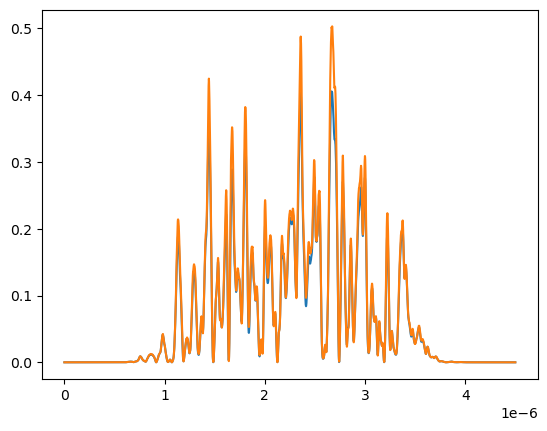

In [44]:
plt.plot(solver.s_arr, np.abs(solver.a_store[idx_check])**2)
plt.plot(solver.s_arr, np.abs(linear_soln)**2)